# Nanopore SARS-CoV-2 analysis
In this notebook we will process the results from the Nanopore run analyzed previously. In this case, the results from the **"[Midnight Protocol](https://labs.epi2me.io/sarscov2-midnight-analysis/)"** will be processed with a a pipeline named epi2me-lab/wf-artic that will take the reads and run the following steps:


*   Install software and prepare environment
*   Run a genome consensus generation pipeline
*   Analyze the results

## Install condacolab

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Check conda using the next command. If no error appears, you're good to go.

In [ ]:
!conda -h

## Install a compatible R to python version 

In [ ]:
#Install a python to R magic compatible with colab
!pip install rpy2==3.5.1

## Download data

In [ ]:
#Download the reads in a zip file and unzip
#The reads will go to nanopore_fastq folder
!gdown 1rRhK7H7R9aiPooqtKtT8kugnLNsqmkkR ; unzip Nanopore_READS.zip

## Install NextFlow

In [3]:
#Establish a few environment variables to make nexflow compatible with colab
import os
os.environ['NXF_VER'] = "20.10.0"
os.environ['NXF_MODE'] = "google"

In [ ]:
#Install nextflow
!curl https://get.nextflow.io | bash


# EPI2ME ARTIC pipeline

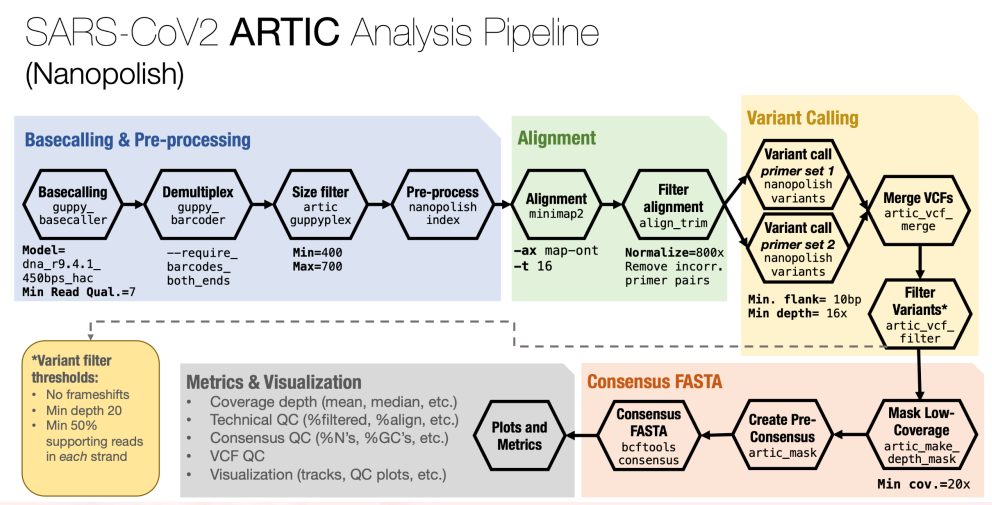


## Install EPI2ME ARTIC pipeline
We will use a modified pipeline that works on this Colab Notebook. If you're going to install in a PC, you can use the nextflow "pull" command, but not here.

In [ ]:
#For your reference, if you use a PC, this is the best way to install the original epi2me/wf-artic pipeline
#We are using a modified version 
#!/content/nextflow pull epi2me-labs/wf-artic            ## This line is commented because should not be executed

Clone a modified version of the pipeline that work in colab

In [ ]:
#Clone the wf-artic repository
!git clone https://github.com/varunshamanna/wf-artic

## Run EPI2ME pipeline

To run the pipeline, we pass the following parameters:


*   `--scheme_version` which is Midnight-ONT/V2
*   `--min_len 200` read minimum length
*   `--max_len 1400` read maximum length
*   `--out_dir` the results will be in this folder
*   `--fastq` the folder containing the reads
*   `-work-dir` where the system will install the software for this pipeline
*   `--sample_sheet` is a file in a csv format with the barcode to sample name relations. The format is: barcode,sample_id,type (for example: `barcode41,hCoV-19_SAMPLE_CODE041,test_sample`)
*   `--report_depth` minimum depth for a base to be called
*   `-profile` which environment management system to use
*   `-resume` can be used to resume a failed or truncated run

*This process will take aprox. 25 minutes in Colab*

In [ ]:
#This is the main command to run the pipeline
#Please take a look at the error in the end
!NXF_VER=20.10.0 /content/nextflow run /content/wf-artic \
  --scheme_version Midnight-ONT/V2 \
  --min_len 200 --max_len 1400 \
  --out_dir /content/result_epi2me \
  --fastq /content/Nanopore_READS/nanopore_fastq/ \
  -work-dir /content/work_epi2me/ \
  --medaka_model r941_min_hac_variant_g507 \
  --sample_sheet /content/Nanopore_READS/nanopore_samples_file.txt \
  --report_depth 20 \
  -profile conda \

## ERROR MESSAGE
The notebook will fail in the last step. This is a Google Colab problem we can't solve... and started a few days ago... To repeat the last steps, and generate the results file so we can continue our notebook we should run the steps below. We need you to check the error message in the last part. It will looks something like:



```
'Work dir:

  /content/work_epi2me/c3/eb22d818e6cad489df369a04a213f7'
  ```

First, install a few python modules


In [ ]:
#install python modules that fails in the previous step
%pip install numpy aplanat pysam

Click on restart the runtime to continue.

Now, we need you to copy the complete PATH, for example `/content/work_epi2me/c3/eb22d818e6cad489df369a04a213f7` and paste it in the next cell where it says **"REPLACE_THIS_TEXT_WITH_PATH"**. Please, check that you need to introduce this in **TWO places** so it can finish the pipeline.
The cells you need to change looks like:



```
os.environ['error_folder'] = "REPLACE_THIS_TEXT_WITH_PATH"   ## REPLACE HERE & keep the quotes
error_folder = "REPLACE_THIS_TEXT_WITH_PATH"                 ## REPLACE HERE & keep the quotes
```
and you need to convert it to (for example)

```
os.environ['error_folder'] = "/content/work_epi2me/c3/eb22d818e6cad489df369a04a213f7"   ## REPLACE HERE & keep the quotes
error_folder = "/content/work_epi2me/c3/eb22d818e6cad489df369a04a213f7"                 ## REPLACE HERE & keep the quotes
```


You need to click in the cell and edit to add the folder names, and then run the cell.

In [ ]:
# This code is to solve a "new" colab problem. Don't worry, is just to generate the
# final reports that failed in the previous step
import os
os.environ['error_folder'] = "REPLACE_THIS_TEXT_WITH_PATH"   ##### REPLACE HERE & keep the quotes
error_folder = "REPLACE_THIS_TEXT_WITH_PATH"                 ##### REPLACE HERE & keep the quotes
%cd $error_folder
!/content/wf-artic/bin/report.py  consensus_status.txt wf-artic-report.html         --pangolin pangolin.csv           --nextclade nextclade.json --hide_debug         --nextclade_errors consensus.errors.csv         --revision null         --commit null         --min_len 200         --max_len 1400         --report_depth 20         --depths depth_stats/*         --summaries read_stats/*         --bcftools_stats vcf_stats/*          --versions versions         --params params.json         --consensus_fasta consensus_fasta         --samples hCoV-19_SAMPLE_CODE041 hCoV-19_SAMPLE_CODE053 hCoV-19_SAMPLE_CODE060 hCoV-19_SAMPLE_CODE070 hCoV-19_SAMPLE_CODE079 hCoV-19_SAMPLE_CODE092 hCoV-19_SAMPLE_CODE093         --types test_sample test_sample test_sample test_sample test_sample test_sample test_sample
!cp $error_folder/wf-artic-report.html /content/result_epi2me/
!echo "pos	depth	depth_fwd	depth_rev	sample_name	primer_set" > all_depth.txt
!cat depth_stats/* | grep -v depth_fwd >> all_depth.txt
!cp all_depth.txt /content/result_epi2me/
%cd /content/


## Analysis of results

The results of the pipeline are saved in this case in the `result_epi2me folder`. The most important results are:
*   `all_consensus.fasta` file. Contains all consensus sequences obtained as a multifasta.
*   `all_depth.txt` is a table which contains the coverage for each position in the consensus genome obtained (where the depth is below 20, the consensus is N).
*   Individual BAM files, names after sample name (hCoV-19_SAMPLE_CODEXX)
*   `wf-artic-report.html` contains a collection of the pipeline results. This is the file to check to understand the results.




In [ ]:
#View all the generated files
!ls -lh result_epi2me/

Download the file `wf-artic-report.html` to open it in a browser.

Here, a few images of the most important features of the report.
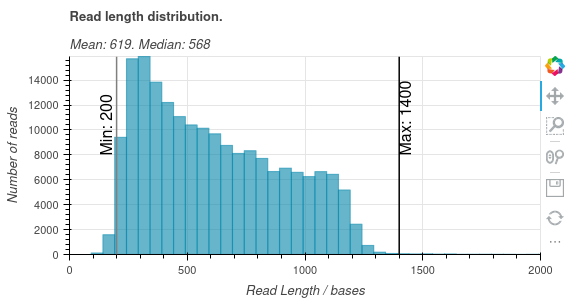

Next, the distribution of reads per barcode.

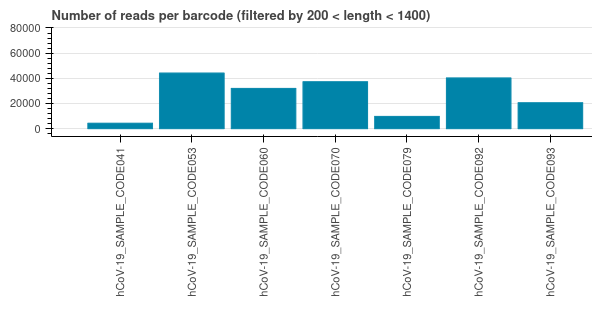

These represents the proportion of each sample in the library. 

### Coverage Analysis

Please, install and load R for python:

In [3]:
%load_ext rpy2.ipython

One of the most important analysis is to check the coverage obtained for different regions of the genome. This is a graphical representation of the depth of coverage for each PCR amplicon in the ARTIC protocol (i.e. the number of reads mapped to each base of the reference genome). You can check 

In [ ]:
# File all_depth is in the result_epi2me folder
%%R
library(ggplot2)
data = read.table("/content/result_epi2me/all_depth.txt", header = TRUE)
ggplot(data, aes(x=pos, y=depth)) + 
  geom_line(color="skyblue") +
  geom_hline(yintercept = 20, col = "red")+ # draw a solid line at 20X
  geom_hline(yintercept = 60, col = "red", linetype = 3) + # draw a dashed line at 60X
  coord_cartesian(ylim = c(0, 500)) +
  facet_wrap(~sample_name)

Let's check the sample hCoV-19_SAMPLE_CODE079. To check each sample individually **you can replace the name of the sample** in the next cell. Also you can change the limits of the graph by changing the `coord_cartesian` lines

In [ ]:
%%R
sampleA = subset(data, data$sample_name == "hCoV-19_SAMPLE_CODE093")
ggplot(sampleA, aes(x=pos, y=depth)) + 
  geom_line(color="skyblue") +
  geom_hline(yintercept = 20, col = "red")+ # draw a solid line at 20X
  geom_hline(yintercept = 60, col = "red", linetype = 3) + # draw a dashed line at 60X
  coord_cartesian(ylim = c(0, 400)) 

Now, we can split the multifasta using an awk oneliner to obtain individual fasta files for each sample, so you can look at them individually. Don't worry, we don't expect you to generate this type of code! Just use it!

In [6]:
!awk '/^>/ {out = substr($1, 2) ".fasta"; print > out} !/^>/ {print >> out}' /content/result_epi2me/all_consensus.fasta

Please, check the sequence in the fasta file of several samples to analyze them individually for any problems.

> **Which samples would you discard?**

> **Which are the "best" sequenced samples?**

> **Any of the samples presents a region with no or low depth?** 

> **What is the relation of the Ns present in the sequences with the coverage?**

A **dropout** is the way to call the absence of coverage in an amplified region. There are several reasons for this. 

*Discuss in the groups what kind of circumstances lead to one or several dropouts.*

## Filtering low quality sequences

Now, we can filter those bad samples based on the N content. To do this you can run:

In [ ]:
#Install datafunk
!pip install https://github.com/aunderwo/datafunk/archive/d608ff89524398469dfefcef7947966fd8c948c6.zip

In [ ]:
#Filter sequences with more than 30% Ns
%cd /content
!mkdir fasta_filtered
!datafunk filter_fasta_by_covg_and_length -i result_epi2me/all_consensus.fasta -o fasta_filtered/sequences_qc_passed.fasta --min-covg 70 --min-length 29000

Now, the file `sequences_qc_passed.fasta` within the folder `fasta_filtered` contains all good sequences (with less than 30% of Ns) to continue the analysis.



---
Developed by Ariel Amadio, Varun Shamanna, Paul Oluniyi and Johan Bernal
